In [212]:
import pandas as pd
# Specify the path to your CSV file
csv_file_path = 'output_data.csv'

# Load the CSV file into a DataFrame
df = pd.read_csv(csv_file_path)

# Display the DataFrame
df.head(2)

,id,date_publish,outlet,headline,lead,body,authors,domain,url,political_leaning,n_words,n_tokens,GPT_causal_graph,formatted_prompt,decoded_output
0,18334433,2018-01-02 12:03:40,BBC,Is parent power driving grammar school expansion?,"Grammars have been growing, with more than 7,5...",Image caption Ruth Cornish wants an academical...,Branwen Jeffreys;Education Editor,www.bbc.com,http://www.bbc.com/news/education-42416365,UNDEFINED,1012,1271,1. [cause] Ruth Cornish's desire for an academ...,### Instruction: Below is an excerpt from a ne...,<s> ### Instruction: Below is an excerpt from ...
1,38951552,2018-01-02 10:56:28,The Guardian,UK manufacturing growth stays strong at end of...,Sector has best three months for growth since ...,Sector has best three months for growth since ...,Richard Partington,www.theguardian.com,https://www.theguardian.com/business/2018/jan/...,LEFT,347,430,1. [cause] Strongest three months for growth s...,### Instruction: Below is an excerpt from a ne...,<s> ### Instruction: Below is an excerpt from ...


In [213]:
import re

def extract_cause_effect_pairs(text):
    # Remove the text after '### End'
    text = text.split('### End')[0]

    # Define the regular expression pattern
    pattern = re.compile(r'\[cause\] (.+?) -> \[effect\] (.+)')

    # Use regex to find all cause and effect pairs in the text
    cause_effect_pairs = re.findall(pattern, text)

    # Check if the cause_effect_pairs list is empty
    if not cause_effect_pairs:
        return None

    # Create a dictionary to store the cause and effect pairs
    result = {cause.strip(): effect.strip() for cause, effect in cause_effect_pairs}

    return result


In [214]:
# Example usage
input_text = """
... [cause] Mother starting to consider selecting schools while child was young -> [effect] Desire for an academically selective education for children
... [cause] Expansion of existing grammar schools -> [effect] Increase in competition among children due to traveling long distances from different regions
... [cause] Government dropping plans for creating new grammar schools due to high controversy -> [effect] Continuation of expansion of current grammar schools
... [cause] Financial difficulties faced by various grammar schools -> [effect] Need for actions including increases in class size and request for volunteered funds
... [cause] Expanding percentage of children receiving grammar school placement -> [effect] Negative consequences for children unable to receive a spot in a grammar school
... [cause] Growth of grammar school expansion -> [effect] Potential significant impact on educational system
... [cause] Each student enrollment bringing in approximately four thousand pounds annually -> [effect] Drive towards expansion by schools facing decline in incoming students
... [cause] Opening of another grammar school nearby -> [effect] Competitive environment within local learning institutions.
... """

cause_effect_pairs = extract_cause_effect_pairs(input_text)
for idx, (cause, effect) in enumerate(cause_effect_pairs.items(), 1):
    print(f"{idx}. [cause] {cause} -> [effect] {effect}")


1. [cause] Mother starting to consider selecting schools while child was young -> [effect] Desire for an academically selective education for children
2. [cause] Expansion of existing grammar schools -> [effect] Increase in competition among children due to traveling long distances from different regions
3. [cause] Government dropping plans for creating new grammar schools due to high controversy -> [effect] Continuation of expansion of current grammar schools
4. [cause] Financial difficulties faced by various grammar schools -> [effect] Need for actions including increases in class size and request for volunteered funds
5. [cause] Expanding percentage of children receiving grammar school placement -> [effect] Negative consequences for children unable to receive a spot in a grammar school
6. [cause] Growth of grammar school expansion -> [effect] Potential significant impact on educational system
7. [cause] Each student enrollment bringing in approximately four thousand pounds annually 

In [215]:
#add another extracted cause and effect column that comes from processing the df['decoded_output'] column use the extract_cause_effect_pairs function
df['llama_extracted_cause_effect_pairs'] = df['decoded_output'].apply(extract_cause_effect_pairs)
df['gpt_extracted_cause_effect_pairs'] = df['GPT_causal_graph'].apply(extract_cause_effect_pairs)

In [216]:
#for df['extracted_cause_effect_pairs'], count the number of nones
print(f"# nan of llama output: {df['llama_extracted_cause_effect_pairs'].isna().sum()}")
print(f"# nan of gpt output: {df['gpt_extracted_cause_effect_pairs'].isna().sum()}")

# nan of llama output: 61
# nan of gpt output: 1


In [217]:
def generate_text_list(cause_effect_dict):
    if cause_effect_dict is None:
        return []
    texts = []
    for cause, effect in cause_effect_dict.items():
        text = f"[cause] {cause} -> [effect] {effect}"
        texts.append(text)
    return texts

In [218]:
#add a column to the df that has the generated text
df['llama_text_list'] = df['llama_extracted_cause_effect_pairs'].apply(generate_text_list)
df['gpt_text_list'] = df['gpt_extracted_cause_effect_pairs'].apply(generate_text_list)

In [219]:
# For column df['llama_text_list'] and df['gpt_text_list']
# Each row has a list of strings, llama as candidates, gpt as references
# Compute the BLEU score row by row of two string lists, notice that for each row, you are comparing two lists of strings, one reference list and one candidate list
from nltk.translate.bleu_score import sentence_bleu
def compute_bleu_score(row):
    bleu_score_corpus = []
    candidates = row['llama_text_list']
    references = row['gpt_text_list']
    if not candidates:
        return 0
    for candidate in candidates:
        bleu_score_corpus.append(sentence_bleu(references, candidate))
    return sum(bleu_score_corpus) / len(bleu_score_corpus)
df['blue_score'] = df.apply(compute_bleu_score, axis=1)

In [220]:
# Print the BLEU score, and max, min, mean
bleu_score = df['blue_score']
print(f"BLEU score: {bleu_score.mean():.2f} +/- {bleu_score.std():.2f}")
print(f"Max: {bleu_score.max():.2f}")
print(f"Min: {bleu_score.min():.2f}")

BLEU score: 0.46 +/- 0.30
Max: 0.82
Min: 0.00


In [221]:
def print_bleu_score_row(row):
    # Print the body
    print("body:")
    print(row['body'])

    # Print the llama_causal_graph
    print("llama_text:")
    llama_causal_graph = row['llama_text_list']
    llama_causal_graph_str = "\n".join(llama_causal_graph)
    print(llama_causal_graph_str)

    # Print the GPT_causal_graph
    print("gpt_text:")
    gpt_causal_graph = row['gpt_text_list']
    gpt_causal_graph_str = "\n".join(gpt_causal_graph)
    print(gpt_causal_graph_str)

# Call the function with the max BLEU score row
print_bleu_score_row(df.iloc[df['blue_score'].idxmax()])

body:
WASHINGTON—The Trump administration is lobbying countries world-wide to support Iranians’ right to peaceful protest and is prepared to impose fresh sanctions if Iran’s government cracks down forcefully on the demonstrations spreading throughout the country, U.S. officials said.
The new U.S. sanctions would be imposed under existing authority to respond to human-rights violations and could be aimed at the Islamic Revolutionary Guard Corps in a bid to minimize doing economic harm to the Iranians carrying out the protests, the...
llama_text:
[cause] The Trump administration's efforts to support Iranian citizens' rights -> [effect] Potential imposition of fresh sanctions against Iran's government for any violent crackdown on the protests
[cause] Protests spreading throughout Iran -> [effect] US preparation to levy new sanctions targeting members of the Islamic Revolutionary Guard Corps.
gpt_text:
[cause] The Trump administration lobbying for support of Iranian's right to protest -> [

In [222]:
# Randomly select 10 rows
random_rows = df.sample(n=10)

#print the 10 rows and their row number, along with BLEU score
for _, row in random_rows.iterrows():
    print(f"Example {row.name}:")
    print_bleu_score_row(row)
    print(f"BLEU score: {row['blue_score']:.2f}")
    print("-" * 50)
    print()


Example 202:
body:
Media playback is unsupported on your device Media caption Footage shows improvised roadblocks and street fires
There are reports of protests breaking out in Iran for a fifth day, despite a statement from the president that the unrest "is nothing".
Anti-government chanting and burning cars were reported as night fell in the capital, Tehran, with other demonstrations across the country.
President Hassan Rouhani said protests were an "opportunity, not a threat" but vowed to crack down on "lawbreakers".
The US meanwhile stepped up support for the protesters' "bold resistance".
The protests began last Thursday in the city of Mashhad, initially against price rises and corruption but now with wider anti-government sentiment.
Where is the violence happening?
The latest reports speak of a heavy police presence in the capital. The Mehr news agency reported a taxi being set alight. Police had used tear gas and water cannon the previous evening to quell a rally in Tehran's Engh

In [223]:
#For the extracted dictionary column, calculate the average number of items in each dictionary and handle none values
number_of_items = df['llama_extracted_cause_effect_pairs'].apply(lambda x: len(x) if x is not None else 0)
print(f"Average number of items in each dictionary (LLAMA): {number_of_items.mean():.2f}")
#For the extracted dictionary column, calculate the average number of items in each dictionary and handle none values
number_of_items = df['gpt_extracted_cause_effect_pairs'].apply(lambda x: len(x) if x is not None else 0)
print(f"Average number of items in each dictionary (GPT): {number_of_items.mean():.2f}")

Average number of items in each dictionary (LLAMA): 3.81
Average number of items in each dictionary (GPT): 6.29


Text(0, 0.5, 'Number of items in the dictionary')

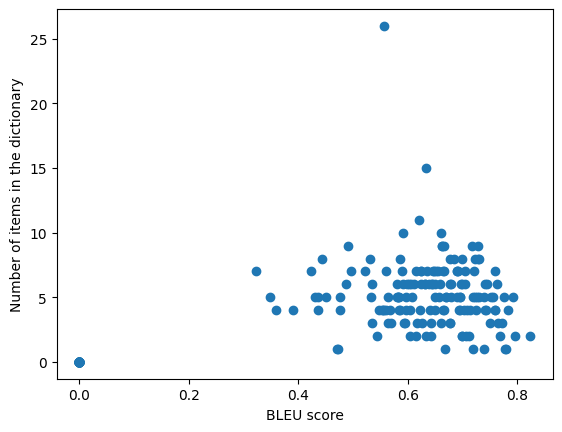

In [224]:
#Is there relationship between number of items in LLAMA and the BLEU score?
import matplotlib.pyplot as plt
plt.scatter(df['blue_score'], df['llama_extracted_cause_effect_pairs'].apply(lambda x: len(x) if x is not None else 0))
plt.xlabel("BLEU score")
plt.ylabel("Number of items in the dictionary")

In [225]:
#Save the df to a csv file
df.to_csv('processed_output_data.csv', index=False)